Trying to remove negatives. Can't understand Parke's code, try my own.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.io.idl import readsav


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [2]:
path = '/media/david/5tb_storage1/muscles/'

In [3]:
testpath = path+ 'stis_hlsp/hlsp_muscles_hst_stis_gj674_g230l_v1_component-spec.ecsv' #testing on the gj674 nuv spectrum

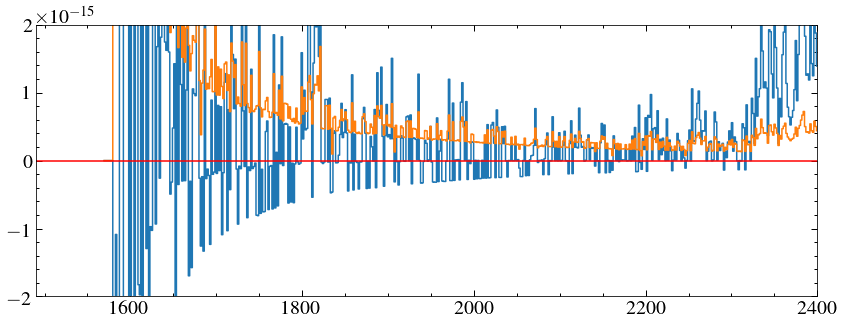

In [4]:
data = Table.read(testpath)
plt.step(data['WAVELENGTH'], data['FLUX'], where='mid')
plt.step(data['WAVELENGTH'], data['ERROR'], where='mid')
#plt.yscale('log')
plt.ylim(-0.2e-14, 0.2e-14)
plt.xlim(right=2400)
plt.axhline(0, c='r')

(array([  2.,   0.,   3.,   1.,   1.,   6.,  67., 315.,  40.,  15.,   7.,
          1.,   3.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-8.1239006e-15, -6.9996888e-15, -5.8754771e-15, -4.7512653e-15,
        -3.6270535e-15, -2.5028415e-15, -1.3786297e-15, -2.5441786e-16,
         8.6979399e-16,  1.9940058e-15,  3.1182175e-15,  4.2424293e-15,
         5.3666411e-15,  6.4908533e-15,  7.6150651e-15,  8.7392768e-15,
         9.8634886e-15,  1.0987700e-14,  1.2111912e-14,  1.3236124e-14,
         1.4360336e-14,  1.5484548e-14,  1.6608759e-14,  1.7732972e-14,
         1.8857183e-14,  1.9981395e-14,  2.1105606e-14,  2.2229819e-14,
         2.3354030e-14,  2.4478243e-14,  2.5602453e-14,  2.6726666e-14,
         2.7850877e-14,  2.8975090e-14,  3.0099302e-14,  3.1223515e-14,
         3

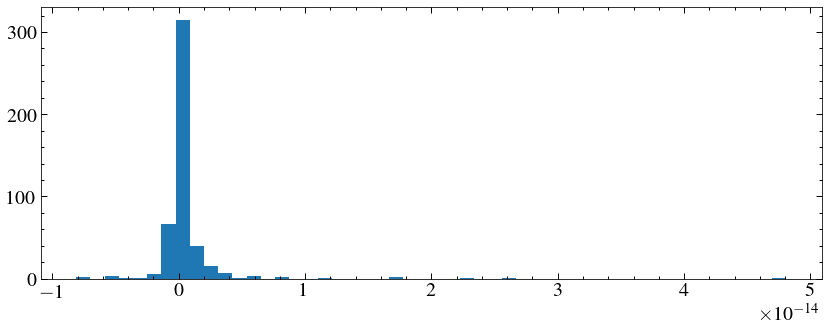

In [5]:
plt.hist(data['FLUX'][(data['WAVELENGTH'] < 2300) & (data['FLUX'] > -1e-14)], bins=50 )

192
1024 1024
88
721 721
3
700 700
0


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


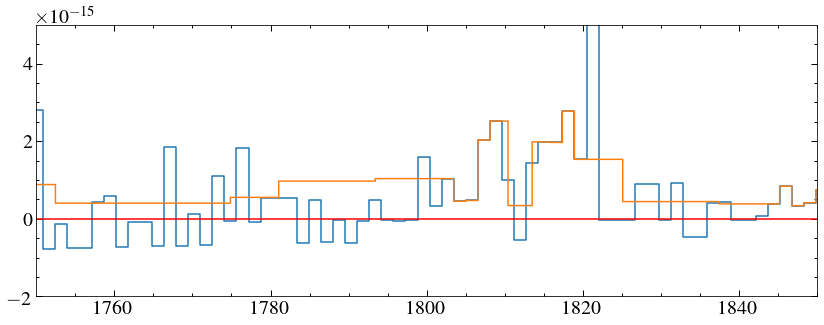

In [6]:
w, f = data['WAVELENGTH'],data['FLUX']
f1 = np.array(f)
w1= np.array(w)
nneg = len(f1[f1 < 0])
print(nneg)

#while nneg > 0:
 #   i = np.argmin(f)
  #  f1[i] = np.sum([f1[i-1], f[i], f[i+1]])
  #  nneg = len(f1[f1 < 0])
plt.step(w, f, where='mid')
trys = 0
inds_to_delete = []
while trys < 1000 and nneg > 0:
    negargs = np.where(f1 < 0)
    #print(len(negargs[0]))
    inds_to_delete = []
    for i in negargs[0]:
        
   #     plt.axvline(w[i])
        #print(i)
        #print(f1[i])
        f1[i] = np.trapz([f1[i-1], f1[i], f1[i+1]], [w1[i-1], w1[i], w1[i+1]])/(w[i+1]-(w[i-1]))
        #f1 = np.delete(f1, [i-1,i+1])
        #w1 = np.delete(w1, [i-1,i+1])
        #print(f1[i])
        inds_to_delete.append((i-1, i+1))
    
    print(len(w1), len(f1))
    nneg = len(f1[f1 < 0])
    print(nneg)
    trys +=1
    f1 = np.delete(f1,np.unique(inds_to_delete))
    w1 = np.delete(w1,np.unique(inds_to_delete))

    
#plt.step(w, f, where='mid')
plt.step(w1, f1, where='mid')
plt.ylim(-0.2e-14, 0.5e-14)
#plt.xlim(right=2400)
plt.xlim(1750, 1850)
plt.axhline(0, c='r')

Great! Need to get that to work with wavelength bins etc, but otherwise it looks good. Do before scaling?

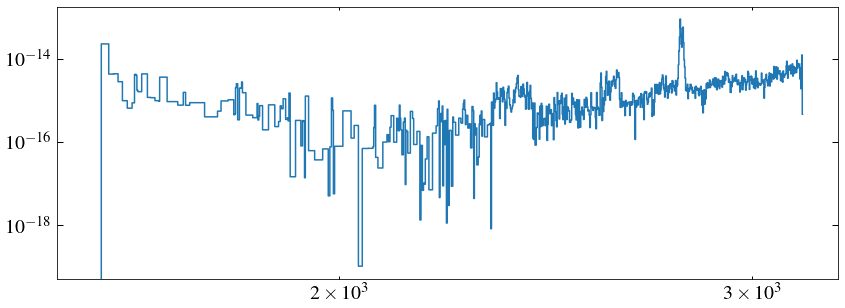

In [7]:
plt.step(w1, f1, where='mid')
plt.yscale('log')
plt.xscale('log')

How does that look compared with the fuv spectrum, scaling wise?

In [8]:
data2 = Table.read(path+ 'stis_hlsp/hlsp_muscles_hst_stis_gj674_g140l_v1_component-spec.ecsv')

(-1e-14, 3e-14)

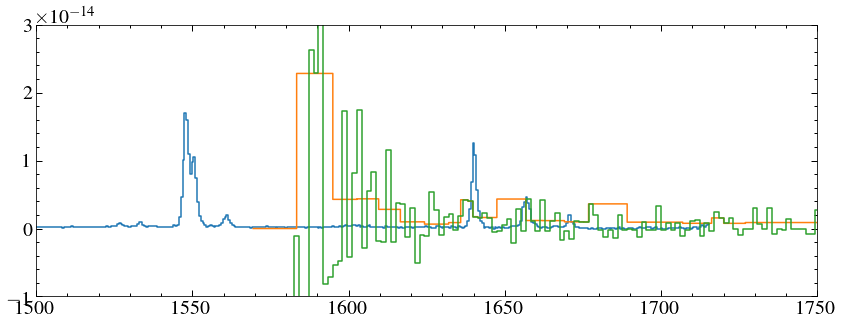

In [9]:
plt.step(data2['WAVELENGTH'], data2['FLUX'], where='mid')
plt.step(w1, f1, where='mid')
plt.step(data['WAVELENGTH'][data['DQ'] == 0], data['FLUX'][data['DQ'] == 0], where='mid')
plt.xlim(1500, 1750)
plt.ylim(-1e-14, 3e-14)

In [10]:
w2, f2 =data2['WAVELENGTH'], data2['FLUX']
mask1 = (w1 < w2[-1])
mask2 = (w2 > w1[0])
int1 = np.trapz(f1[mask1], w1[mask1])
int2 = np.trapz(f2[mask2], w2[mask2])
print(int1, int2)
print(int1/int2)

5.205396617364141e-13 6.77030364069092e-14
7.688571877454114


What does this do to T1?

In [20]:
t1data = Table.read('quicksaves/2MASS-J23062928-0502285_basic.ecsv')
wt, ft, et = t1data['WAVELENGTH'], t1data['FLUX'], t1data['ERROR']

-1.688726304688228e-15


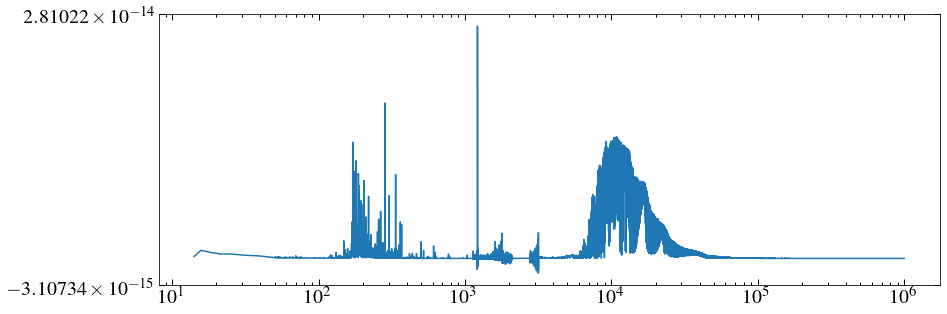

In [51]:
plt.plot(wt,ft)
plt.yscale('symlog')
plt.xscale('log')
#plt.ylim(-2e-14,2e-14)
print(min(ft))

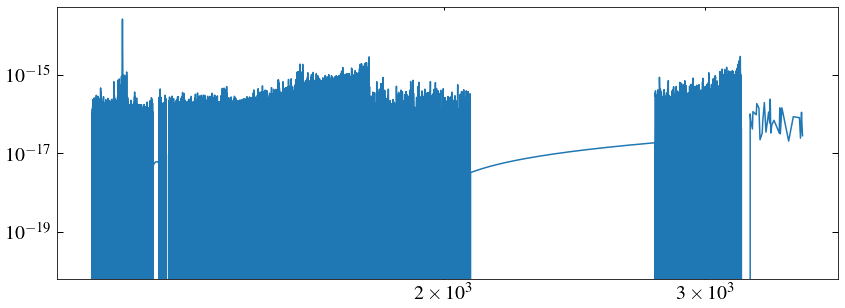

In [22]:
band = (wt > 1160) & (wt < 3500)
plt.plot(wt[band], ft[band])
plt.yscale('log')
plt.xscale('log')

34176
55075 55075
28076
9232 9232
832


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.


6262 6262
59
5973 5973
23
5913 5913
21
5871 5871
21
5829 5829
21
5788 5788
21
5746 5746
19
5708 5708
19
5670 5670
19
5633 5633
19
5595 5595
17
5561 5561
17
5527 5527
17
5493 5493
17
5459 5459
17
5425 5425
17
5391 5391
17
5357 5357
17
5323 5323
17
5289 5289
17
5255 5255
17
5221 5221
17
5187 5187
17
5154 5154
17
5120 5120
15
5090 5090
15
5060 5060
15
5030 5030
15
5001 5001
15
4971 4971
13
4945 4945
13
4919 4919
13
4893 4893
13
4867 4867
13
4841 4841
13
4815 4815
13
4789 4789
13
4763 4763
13
4737 4737
13
4711 4711
13
4685 4685
13
4659 4659
13
4633 4633
13
4607 4607
13
4581 4581
13
4555 4555
13
4529 4529
13
4503 4503
13
4477 4477
13
4451 4451
13
4425 4425
11
4403 4403
11
4381 4381
11
4359 4359
11
4337 4337
11
4315 4315
11
4293 4293
11
4271 4271
11
4249 4249
11
4227 4227
11
4205 4205
9
4187 4187
9
4169 4169
9
4151 4151
9
4133 4133
9
4115 4115
9
4097 4097
9
4079 4079
9
4061 4061
9
4043 4043
9
4025 4025
9
4007 4007
9
3989 3989
9
3971 3971
9
3953 3953
9
3935 3935
9
3917 3917
9
3899 3899
9
3881

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars


3675 3675
7
3661 3661
7
3647 3647
7
3633 3633
7
3619 3619
7
3605 3605
7
3591 3591
7
3577 3577
7
3564 3564
7
3550 3550
5
3540 3540
5
3530 3530
5
3520 3520
5
3510 3510
5
3500 3500
5
3490 3490
5
3480 3480
5
3470 3470
5
3460 3460
5
3450 3450
5
3440 3440
5
3430 3430
5
3420 3420
5
3410 3410
5
3400 3400
5
3390 3390
5
3380 3380
5
3370 3370
5
3360 3360
5
3350 3350
5


/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:4062: RuntimeWarning: overflow encountered in multiply
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)


3340 3340
5
3330 3330
5
3320 3320
5
3310 3310
5
3300 3300
5
3290 3290
5
3280 3280
5
3270 3270
5
3260 3260
5
3250 3250
5
3240 3240
5
3230 3230
5
3220 3220
5
3210 3210
5
3200 3200
5
3190 3190
5
3180 3180
5
3170 3170
5
3160 3160
5
3150 3150
5
3140 3140
5
3130 3130
5
3120 3120
5
3110 3110
5
3100 3100
5
3090 3090
5
3080 3080
5
3070 3070
5
3060 3060
5
3050 3050
5
3040 3040
5
3030 3030
5
3020 3020
5
3010 3010
5
3000 3000
5
2990 2990
5
2980 2980
5
2970 2970
5
2960 2960
5
2950 2950
5
2940 2940
5
2930 2930
5
2920 2920
5
2910 2910
5
2900 2900
5
2890 2890
5
2880 2880
5
2870 2870
5
2860 2860
5
2850 2850
5
2840 2840
5
2830 2830
5
2820 2820
5
2810 2810
5
2800 2800
5
2790 2790
5
2780 2780
5
2770 2770
5
2760 2760
5
2750 2750
5
2740 2740
5
2730 2730
5
2720 2720
5
2710 2710
5
2700 2700
5
2690 2690
5
2680 2680
5
2670 2670
5
2660 2660
5
2650 2650
5
2641 2641
5
2631 2631
3
2625 2625
1


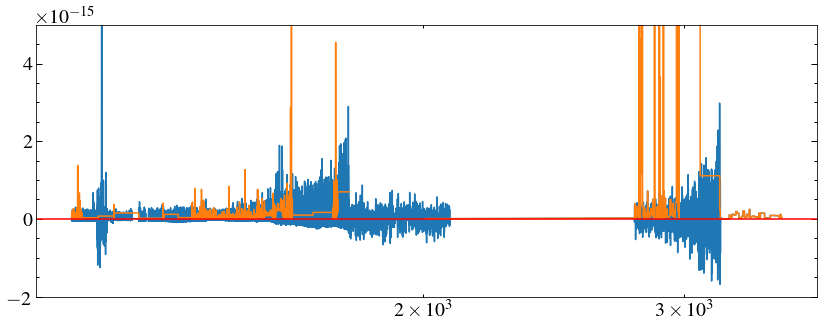

In [25]:
w, f = wt[band], ft[band]
f1 = np.array(f)
w1= np.array(w)
nneg = len(f1[f1 < 0])
print(nneg)

#while nneg > 0:
 #   i = np.argmin(f)
  #  f1[i] = np.sum([f1[i-1], f[i], f[i+1]])
  #  nneg = len(f1[f1 < 0])
plt.step(w, f, where='mid')
trys = 0
inds_to_delete = []
while trys < 1000 and nneg > 1:
    negargs = np.where(f1 < 0)
    #print(len(negargs[0]))
    inds_to_delete = []
    for i in negargs[0]:
        
   #     plt.axvline(w[i])
        #print(i)
        #print(f1[i])
        f1[i] = np.trapz([f1[i-1], f1[i], f1[i+1]], [w1[i-1], w1[i], w1[i+1]])/(w[i+1]-(w[i-1]))
        #f1 = np.delete(f1, [i-1,i+1])
        #w1 = np.delete(w1, [i-1,i+1])
        #print(f1[i])
        inds_to_delete.append((i-1, i+1))
    
    print(len(w1), len(f1))
    nneg = len(f1[f1 < 0])
    print(nneg)
    trys +=1
    f1 = np.delete(f1,np.unique(inds_to_delete))
    w1 = np.delete(w1,np.unique(inds_to_delete))

    
#plt.step(w, f, where='mid')
plt.step(w1, f1, where='mid')
plt.ylim(-0.2e-14, 0.5e-14)
#plt.xlim(right=2400)
#plt.xlim(1750, 1850)
plt.xscale('log')
plt.axhline(0, c='r')